In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"


import torch
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from typing import List, Dict

In [2]:
def _flatten_s_test_list(s_test_list: List[torch.Tensor]) -> torch.Tensor:
    s_tests = [s_test.flatten() for s_test in s_test_list]
    return torch.cat(s_tests)


def _parse_file_name(file_name: str) -> Dict:
    base_file_name = os.path.basename(file_name)
    items = base_file_name.split(".")
    return {
        "correct": (True if items[1] == "only-correct" else False),
        "test_index": int(items[3]),
        "num_samples": int(items[4]),
        "batch_size": int(items[5]),
        "repetition": int(items[6]),
        "hostname": items[8],
    }


def _load_and_populate_dict_(file_name: str, dict_to_populate: Dict) -> None:
    data = torch.load(file_name)
    if data["test_index"] != dict_to_populate["test_index"]:
        raise ValueError
        
    if data["num_samples"] != dict_to_populate["num_samples"]:
        raise ValueError
        
    if data["batch_size"] != dict_to_populate["batch_size"]:
        raise ValueError
        
    if data["repetition"] != dict_to_populate["repetition"]:
        raise ValueError
        
    if data["correct"] != dict_to_populate["correct"]:
        raise ValueError

    dict_to_populate["time_elapsed"] = data["time_elapsed"]    
    dict_to_populate["s_test"] = _flatten_s_test_list(data["s_test"])

    
def _find_corresponding_source_s_test(entry: pd.Series) -> torch.Tensor:
    corresponding_entry = output_collections_df.loc[
        (output_collections_df.test_index == entry["test_index"]) &
        (output_collections_df.repetition <= entry["repetition"]) &
        (output_collections_df.num_samples == entry["num_samples"]) &
        (output_collections_df.batch_size == entry["batch_size"]),
        "s_test"
    ]

    if corresponding_entry.shape[0] != (entry["repetition"] + 1):
        raise ValueError
    # print(corresponding_entry.shape[0])

    return torch.stack(corresponding_entry.tolist()).mean(dim=0)


def _find_corresponding_target_s_test(entry: pd.Series) -> torch.Tensor:
    corresponding_entry = output_collections_df.loc[
        (output_collections_df.test_index == entry["test_index"]) &
        # (output_collections_df.repetition == entry["repetition"]) &
        (output_collections_df.num_samples == max_num_samples) &
        (output_collections_df.batch_size == max_batch_size),
        "s_test"
    ]
    
    if corresponding_entry.shape[0] != 4:
        raise ValueError

    return torch.stack(corresponding_entry.tolist()).mean(dim=0)


output_collections = []
for file_name in tqdm(glob("/export/home/hguo/Experiments/20201018/*/*")):
    # The experiments for these indices haven't finished.
    if "only-correct.10.5" in file_name:
        continue
    if "only-incorrect.10.25" in file_name:
        continue
    output_collection = _parse_file_name(file_name)
    _load_and_populate_dict_(file_name, output_collection)
    output_collections.append(output_collection)

100%|██████████| 2154/2154 [35:39<00:00,  1.01it/s]  


In [11]:
max_batch_size = max([o["batch_size"] for o in output_collections])
max_num_samples = max([o["num_samples"] for o in output_collections])
max_batch_size, max_num_samples

(128, 1300)

In [12]:
output_collections_df = pd.DataFrame(output_collections)
output_collections_df["diff_norm"] = output_collections_df.apply(
    lambda x: (_find_corresponding_source_s_test(x) -
               _find_corresponding_target_s_test(x)).norm().item(), axis=1)
output_collections_df

,correct,test_index,num_samples,batch_size,repetition,hostname,time_elapsed,s_test,diff_norm
0,True,4,700,2,2,uncertainty-medium-dshm-20201018-0-7rnw4,37.742831,"[tensor(1.7285e-09), tensor(1.2903e-08), tenso...",0.000018
1,True,0,800,64,2,uncertainty-medium-dshm-20201018-0-7rnw4,268.603928,"[tensor(-8.9802e-08), tensor(1.0910e-08), tens...",0.000220
2,True,2,700,128,2,uncertainty-medium-dshm-20201018-0-7rnw4,448.822966,"[tensor(8.0436e-09), tensor(-4.9086e-08), tens...",0.000355
3,True,1,900,8,2,uncertainty-medium-dshm-20201018-0-7rnw4,51.110801,"[tensor(-3.0259e-10), tensor(1.1757e-08), tens...",0.000016
4,True,2,1100,32,2,uncertainty-medium-dshm-20201018-0-7rnw4,188.678238,"[tensor(4.3538e-09), tensor(-3.2043e-08), tens...",0.000078
...,...,...,...,...,...,...,...,...,...
1787,False,3,1200,1,2,uncertainty-medium-dshm-20201018-0-7rnw4,81.517129,"[tensor(1.5504e-07), tensor(3.2176e-09), tenso...",0.000109
1788,False,14,1100,8,1,uncertainty-medium-dshm-20201018-0-7rnw4,79.123226,"[tensor(-2.3598e-07), tensor(-2.2160e-07), ten...",0.000165
1789,False,14,1100,4,0,uncertainty-medium-dshm-20201018-0-7rnw4,78.210011,"[tensor(-2.5462e-07), tensor(-2.2022e-07), ten...",0.000172
1790,False,3,800,128,1,uncertainty-medium-dshm-20201018-0-7rnw4,512.785513,"[tensor(2.3406e-07), tensor(-2.7671e-09), tens...",0.000475


In [47]:
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from collections import defaultdict
def _collect_diff_and_time_statistics(
        df: pd.DataFrame
) -> Tuple[Dict[int, Dict[int, Tuple[float, float]]],
           Dict[int, Dict[int, Tuple[float, float]]]]:

    dfmeans = df.groupby(["num_samples", "batch_size", "repetition", "correct"]).mean()[["time_elapsed", "diff_norm"]]
    dfstds = df.groupby(["num_samples", "batch_size", "repetition", "correct"]).std()[["time_elapsed", "diff_norm"]]

    time_data_dicts = []
    diff_data_dicts = []
    for row_m, row_s in zip(dfmeans.iterrows(), dfstds.iterrows()):
        # The first element is a tuple of `(num_samples, batch_size, repetition, correct)`
        if row_m[0] != row_s[0]:
            raise ValueError
        n, b, r, c = row_m[0]
        time_data = {
            "num_samples": n,
            "batch_size": b,
            "repetition": r,
            "correct": c,
            "mean": row_m[1].time_elapsed,
            "std": row_s[1].time_elapsed,
        }
        diff_data = {
            "num_samples": n,
            "batch_size": b,
            "repetition": r,
            "correct": c,
            "mean": row_m[1].diff_norm,
            "std": row_s[1].diff_norm,
        }
        time_data_dicts.append(time_data)
        diff_data_dicts.append(diff_data)

    display(dfmeans.transpose())
    display(dfstds.transpose())
    return pd.DataFrame(time_data_dicts), pd.DataFrame(diff_data_dicts)

In [67]:
output_collections_df.test_index.unique()

array([ 4,  0,  2,  1, 24, 14, 15,  3])

In [128]:
time_data_dicts, diff_data_dicts = _collect_diff_and_time_statistics(output_collections_df)

num_samples        700                                               \
batch_size          1                                                 
repetition            0                     1                     2   
correct           False      True       False      True       False   
time_elapsed  48.494500  36.784938  48.262706  37.243059  47.250733   
diff_norm      0.001081   0.000188   0.001049   0.000182   0.001041   

num_samples                                                          ...  \
batch_size                                           2               ...   
repetition                       3                     0             ...   
correct           True       False      True       False      True   ...   
time_elapsed  37.078008  47.222095  37.151793  47.385495  36.487507  ...   
diff_norm      0.000181   0.001036   0.000179   0.001039   0.000182  ...   

num_samples         1300                                                  \
batch_size           64                      128                           
repetition             3                       0                       1   
correct            False       True        False       True        False   
time_elapsed  437.107683  436.798756  834.010190  832.740034  834.161200   
diff_norm       0.000012    0.000002    0.000011    0.000002    0.000007   

num_samples                                                                 
batch_size                                                                  
repetition                         2                         3              
correct            True        False         True        False       True   
time_elapsed  832.915509  834.010312  8.329895e+02  834.030229  833.065596  
diff_norm       0.000001    0.000004  8.067985e-07    0.000000    0.000000  

[2 rows x 448 columns]

num_samples       700                                                    \
batch_size         1                                                      
repetition           0                  1                   2             
correct          False    True      False     True      False     True    
time_elapsed  2.372639  2.25459  2.148351  2.530057  0.729600  2.565148   
diff_norm     0.000397  0.00019  0.000396  0.000185  0.000392  0.000184   

num_samples                                           ...      1300            \
batch_size                             2              ...       64              
repetition           3                   0            ...         3             
correct          False     True      False     True   ...     False     True    
time_elapsed  2.453161  2.601808  2.554728  2.755938  ...  0.368538  0.567910   
diff_norm     0.000392  0.000181  0.000390  0.000184  ...  0.000003  0.000002   

num_samples                                                         \
batch_size         128                                               
repetition           0                   1                       2   
correct          False     True      False     True          False   
time_elapsed  0.883204  0.499175  0.914322  0.667057  1.037769e+00   
diff_norm     0.000003  0.000002  0.000002  0.000001  9.823774e-07   

num_samples                                    
batch_size                                     
repetition                         3           
correct              True      False    True   
time_elapsed  6.714990e-01  0.826965  0.85045  
diff_norm     8.766656e-07  0.000000  0.00000  

[2 rows x 448 columns]

In [129]:
# dfmeans = output_collections_df[output_collections_df.correct == False].groupby(["num_samples", "batch_size"]).mean()[["time_elapsed", "diff_norm"]]
# dfstds = output_collections_df[output_collections_df.correct == False].groupby(["num_samples", "batch_size"]).std()[["time_elapsed", "diff_norm"]]
# time_data = defaultdict(dict)
# diff_data = defaultdict(dict)
# for row_m, row_s in zip(dfmeans.iterrows(), dfstds.iterrows()):
#     if row_m[0] != row_s[0]:
#         raise ValueError
#     n, b = row_m[0]
#     time_data[n][b] = (row_m[1].time_elapsed, row_s[1].time_elapsed)
#     diff_data[n][b] = (row_m[1].diff_norm, row_s[1].diff_norm)
    

# display(dfmeans.transpose())
# display(dfstds.transpose())

# display(time_data_dicts), display(diff_data_dicts)
merged_data_dicts = pd.merge(
    time_data_dicts, diff_data_dicts,
    on=["num_samples", "batch_size", "repetition", "correct"],
    suffixes=("_time", "_diff"))
merged_data_dicts

,num_samples,batch_size,repetition,correct,mean_time,std_time,mean_diff,std_diff
0,700,1,0,False,48.494500,2.372639,1.080633e-03,3.968305e-04
1,700,1,0,True,36.784938,2.254590,1.876754e-04,1.899445e-04
2,700,1,1,False,48.262706,2.148351,1.049045e-03,3.956856e-04
3,700,1,1,True,37.243059,2.530057,1.823152e-04,1.848827e-04
4,700,1,2,False,47.250733,0.729600,1.041399e-03,3.924520e-04
...,...,...,...,...,...,...,...,...
443,1300,128,1,True,832.915509,0.667057,1.276981e-06,1.369583e-06
444,1300,128,2,False,834.010312,1.037769,3.958993e-06,9.823774e-07
445,1300,128,2,True,832.989498,0.671499,8.067985e-07,8.766656e-07
446,1300,128,3,False,834.030229,0.826965,0.000000e+00,0.000000e+00


In [130]:
# merged_data_dicts[
#     (merged_data_dicts.repetition == 0) &
#     (merged_data_dicts.correct == True)].mean_time.values, merged_data_dicts[
#     (merged_data_dicts.repetition == 0) &
#     (merged_data_dicts.correct == False)].mean_time.values

# merged_data_dicts[
#     (merged_data_dicts.repetition == 3) &
#     (merged_data_dicts.batch_size == 1) &
#     (merged_data_dicts.correct == True)].mean_diff.values, merged_data_dicts[
#     (merged_data_dicts.repetition == 0) &
#     (merged_data_dicts.batch_size == 1) &
#     (merged_data_dicts.correct == True)].mean_diff.values

# output_collections_df.groupby(["num_samples", "batch_size", "repetition", "correct"])[["time_elapsed", "diff_norm"]].max()
# [o["time_elapsed"] for o in output_collections if o["test_index"] == 3 and o["num_samples"] == 700 and o["batch_size"] == 1]

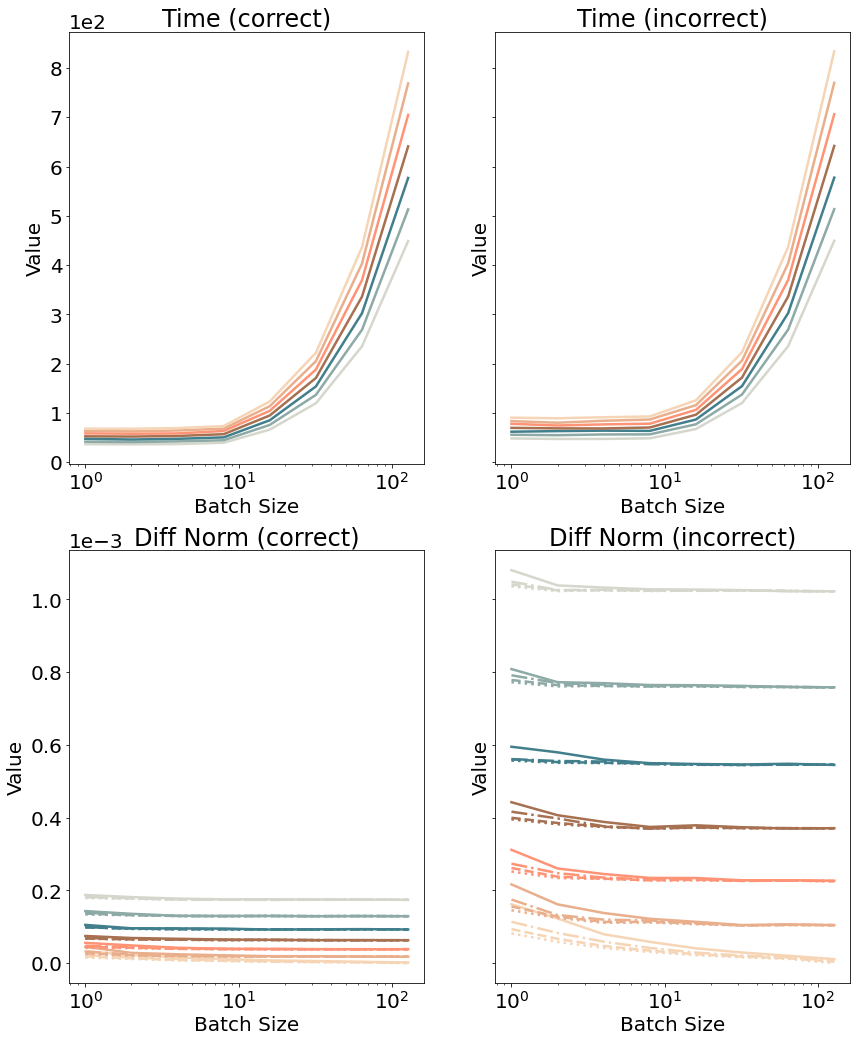

In [131]:
plt.rcParams.update({"font.size": 20})

def make_plot(data, name, title, axis, linestyle=None, add_legend=True, log_x=True, log_y=False):
    for k in sorted(data.num_samples.unique()):
        # plt.errorbar(Xs, Ys, yerr=Ys_e, label=f"N={k}")
        Xs = data[data.num_samples == k].batch_size;
        Ys = data[data.num_samples == k][f"mean_{name}"]
        Ys_e = data[data.num_samples == k][f"std_{name}"]
        axis.plot(Xs, Ys, label=f"J={k}", linewidth=2.5, linestyle=linestyle, color={
            700: "#D5D7CC",
            800: "#8DAAA6",
            900: "#427F8C",
            1000: "#A67051",
            1100: "#FF9376",
            1200: "#E9AE8C",
            1300: "#F6D5B6"}[k])
    
    if add_legend:
        axis.legend()
    axis.set_title(title)
    axis.set_xlabel("Batch Size")
    axis.set_ylabel("Value")
    if log_x:
        axis.set_xscale("log")
    if log_y:
        axis.set_yscale("log")
    if not log_y:
        # This doesn't work with `log_y`
        axis.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    # plt.savefig("./20201013-stest-speedup-time.pdf")

figure, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex="row",
    sharey="row",
    figsize=(7 * 2, 7 * 2.5))

make_plot(merged_data_dicts[
    (merged_data_dicts.repetition == 0) &
    (merged_data_dicts.correct == True)],
    name="time",
    title="Time (correct)",
    add_legend=False,
    axis=axes[0, 0])

make_plot(merged_data_dicts[
    (merged_data_dicts.repetition == 0) &
    (merged_data_dicts.correct == False)],
    name="time",
    title="Time (incorrect)",
    add_legend=False,
    axis=axes[0, 1])


for repetition, linestyle in zip(range(4), ["dotted", "dashed", "dashdot", "solid"][::-1]):
    make_plot(merged_data_dicts[
        (merged_data_dicts.repetition == repetition) &
        (merged_data_dicts.correct == True)],
        name="diff",
        title="Diff Norm (correct)",
        linestyle=linestyle,
        add_legend=False,
        axis=axes[1, 0])

    make_plot(merged_data_dicts[
        (merged_data_dicts.repetition == repetition) &
        (merged_data_dicts.correct == False)],
        name="diff",
        title="Diff Norm (incorrect)",
        linestyle=linestyle,
        add_legend=False,
        axis=axes[1, 1])

# figure.legend(ncol=5)

In [127]:
# figure.savefig("./20201028-stest-combined.pdf")